In [1]:
import numpy as np
from multiprocessing import Queue
import pandas as pd
import redis
import time
import datetime
import matplotlib.pyplot as plt
import pickle
import os
from os.path import join, isfile
import seaborn as sns
sns.set()
from itertools import product
import warnings
warnings.filterwarnings('ignore')
import matplotlib.backends.backend_pdf
from tqdm import tqdm
from scipy.stats import zscore, linregress
import pickle

In [2]:
def convolve(timeseries, window_small, window_large, bin_size=5, min_occurrences=600):

    series1 = np.convolve(timeseries, np.ones(int(window_small/bin_size)), mode="valid")
    series2 = np.convolve(timeseries, np.ones(int(window_large/bin_size)), mode="valid")
        
    stride = series1.shape[0] - series2.shape[0]
    series1 = series1[stride:]

    result = np.nan_to_num(series1 / series2, nan=0.) * (window_large/window_small)
    result[result == 0] = 1

    # two sided anomalies
    #pos = np.where(result < 1)[0]
    #result[pos] = 1/result[pos]
    
    #print(result)
    
    f = lambda n: 1/(1+np.e**-n)  # normalize to [0;1]
    f = lambda n: n  # identity function
    
    return np.array(list(map(f, result)))
    

In [3]:
def convolve_zscore(timeseries, window_small, window_large, bin_size=5, min_occurrences=600):
    
    length = timeseries.shape[0] - int(window_large/bin_size)
    result = np.zeros(length)

    for i in range(length):
        series = timeseries[i:i + int(window_large/bin_size)]
        result[i] = np.abs(zscore(series)[-1])

    f = lambda n: 1/(1+np.e**-n)  # normalize to [0;1]
    f = lambda n: n  # identity function
    return np.array(list(map(f, result)))

In [4]:
def convolve_residual(timeseries, window_small, window_large, bin_size=5, min_occurrences=600):
    
    length = timeseries.shape[0] - int(window_large/bin_size)
    result = np.zeros(length)
    x = np.array([i for i in range(int(window_large/bin_size))])

    for i in range(length):
        series = np.asarray(timeseries[i:i + int(window_large/bin_size)])
        reg = linregress(x, series)
        m = reg.slope
        t = reg.intercept
           
        residual = series[-1] - (m * int(window_large/bin_size) + t)
        residual *= residual
        result[i] = max(residual, 1)
                    
    result = np.log(result)
    f = lambda n: 1/(1+np.e**-n)  # normalize to [0;1]
    f = lambda n: n  # identity function
    
    return np.array(list(map(f, result)))

Starting GridSearch - Params: 5/2880 with detector ratio
Next Dataset: 'Apple.csv'
                timestamp  value  anomaly_score
0     2020-01-01 19:55:00      1       0.000000
1     2020-01-01 20:00:00      3       0.000000
2     2020-01-01 20:05:00      2       0.000000
3     2020-01-01 20:15:00      3       0.000000
4     2020-01-01 20:20:00      5       0.000000
...                   ...    ...            ...
16061 2020-02-29 23:25:00      1       0.563990
16062 2020-02-29 23:30:00      6       0.823780
16063 2020-02-29 23:35:00      2       0.625703
16064 2020-02-29 23:40:00      5       0.782935
16065 2020-02-29 23:45:00      1       0.563821

[16066 rows x 3 columns]
Next Dataset: 'Facebook.csv'
                timestamp  value  anomaly_score
0     2020-01-01 19:55:00      3       0.000000
1     2020-01-01 20:00:00      4       0.000000
2     2020-01-01 20:05:00      1       0.000000
3     2020-01-01 20:10:00      3       0.000000
4     2020-01-01 20:15:00      4       0.00000

Next Dataset: 'Facebook.csv'
                timestamp  value  anomaly_score
0     2020-01-01 19:55:00      3       0.000000
1     2020-01-01 20:00:00      4       0.000000
2     2020-01-01 20:05:00      1       0.000000
3     2020-01-01 20:10:00      3       0.000000
4     2020-01-01 20:15:00      4       0.000000
...                   ...    ...            ...
16735 2020-02-29 23:25:00      3       0.587160
16736 2020-02-29 23:30:00      5       0.693241
16737 2020-02-29 23:35:00      1       0.539743
16738 2020-02-29 23:40:00      2       0.690614
16739 2020-02-29 23:45:00      1       0.632140

[16740 rows x 3 columns]
Next Dataset: 'Google.csv'
                timestamp  value  anomaly_score
0     2020-01-01 19:55:00      2       0.000000
1     2020-01-01 20:00:00      9       0.000000
2     2020-01-01 20:05:00      3       0.000000
3     2020-01-01 20:10:00      7       0.000000
4     2020-01-01 20:15:00      5       0.000000
...                   ...    ...            ...
16919 

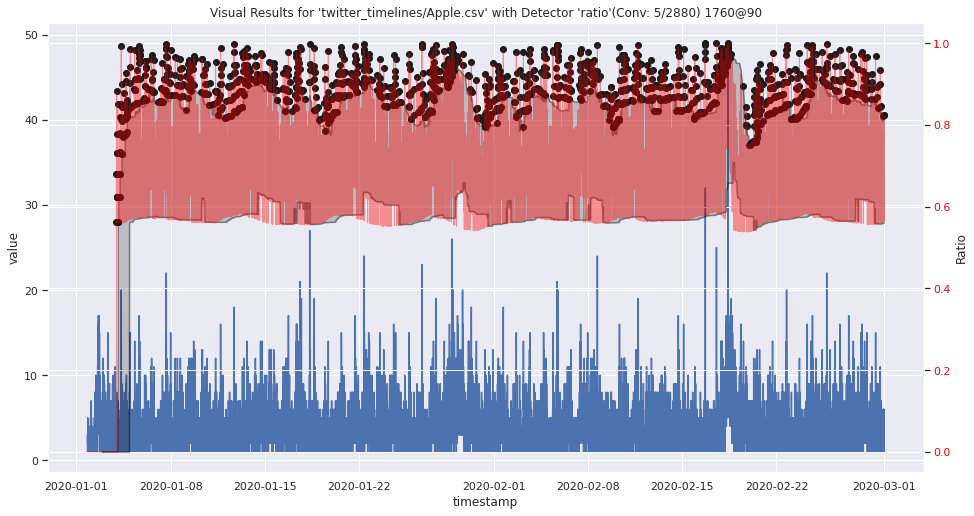

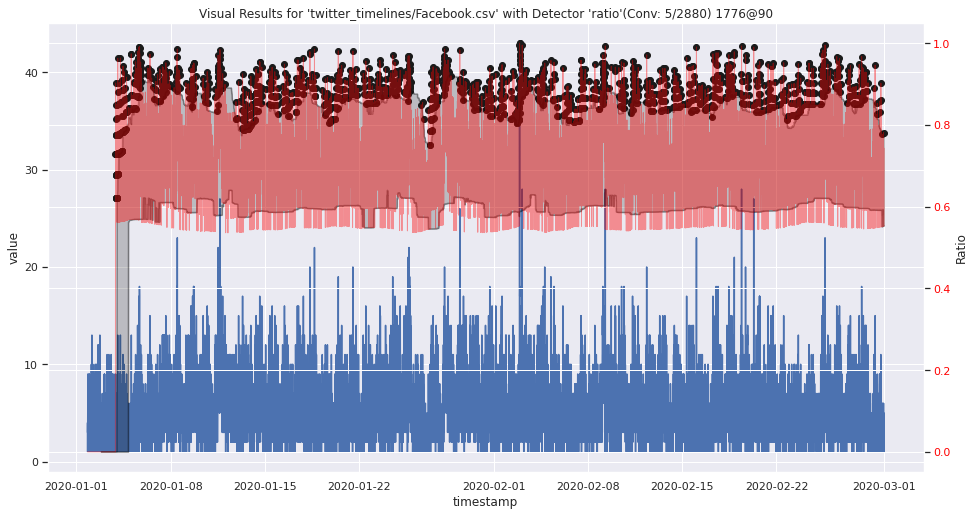

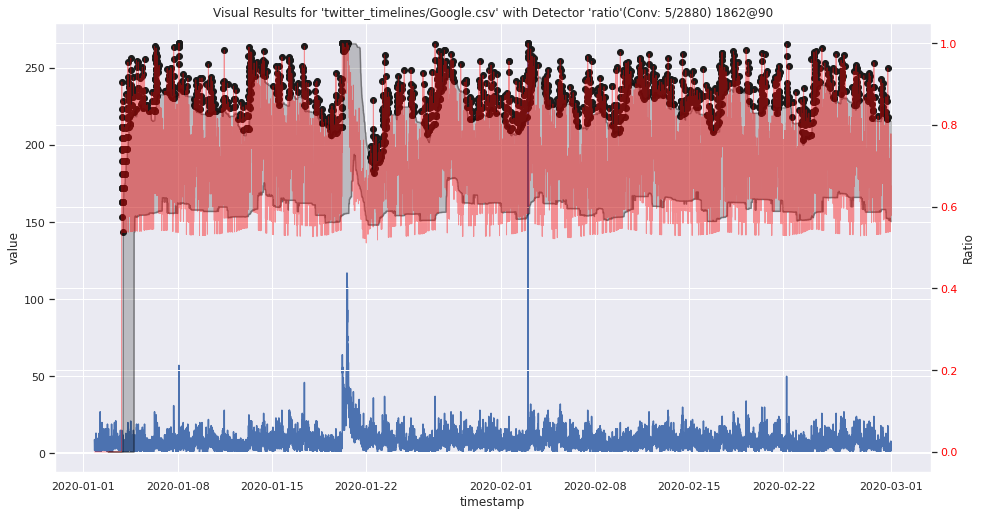

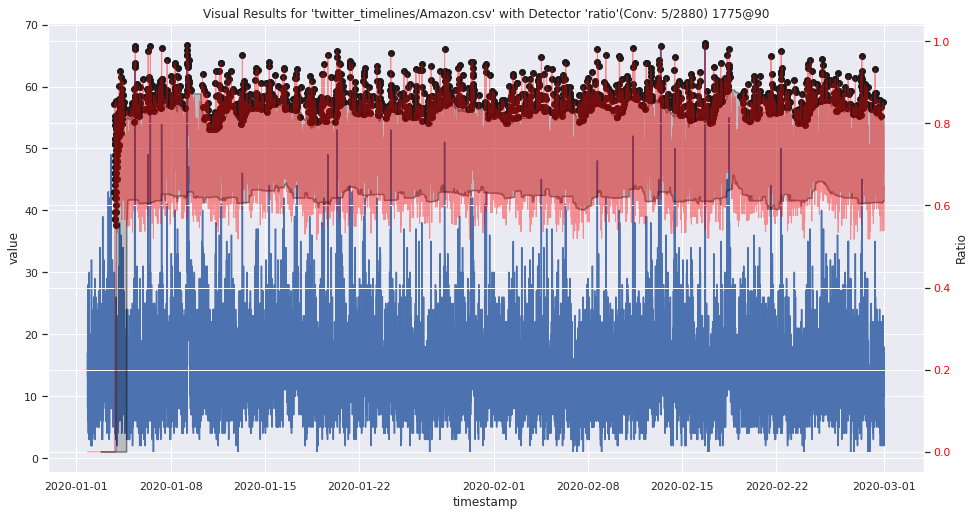

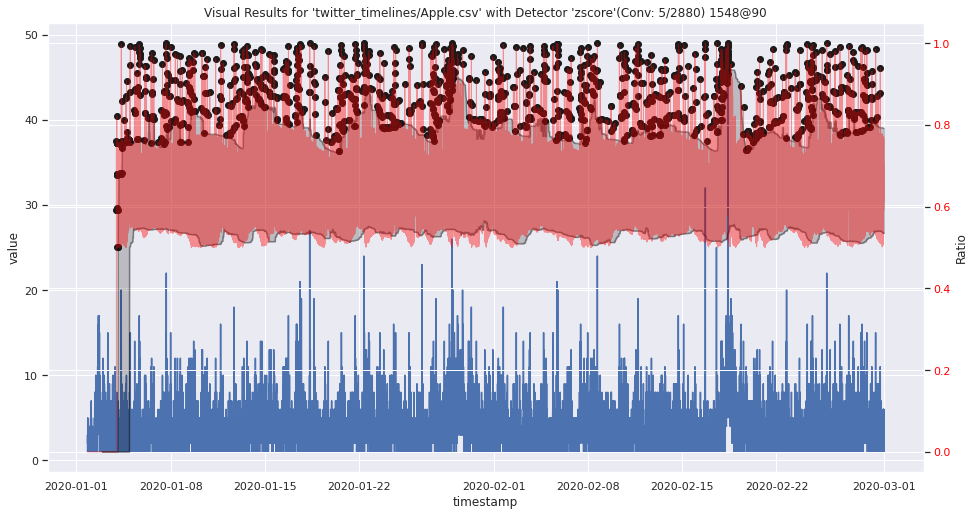

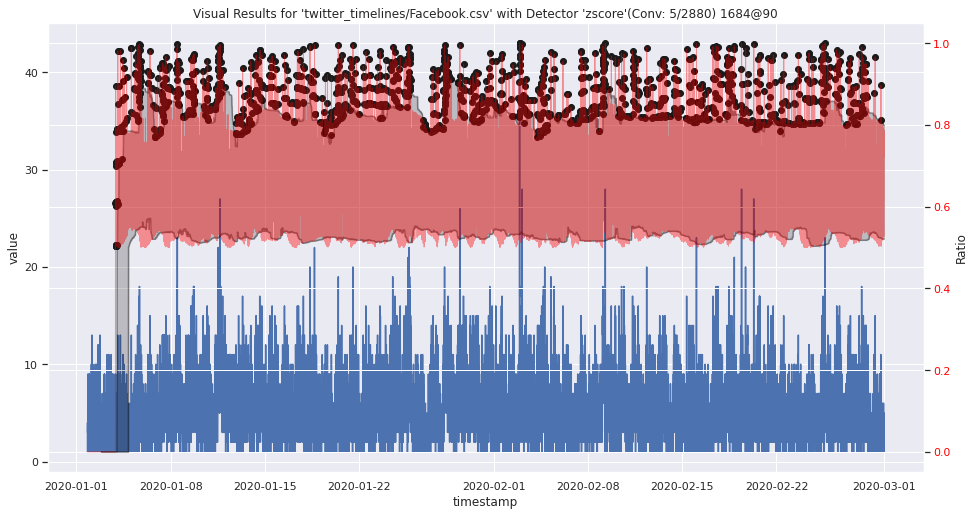

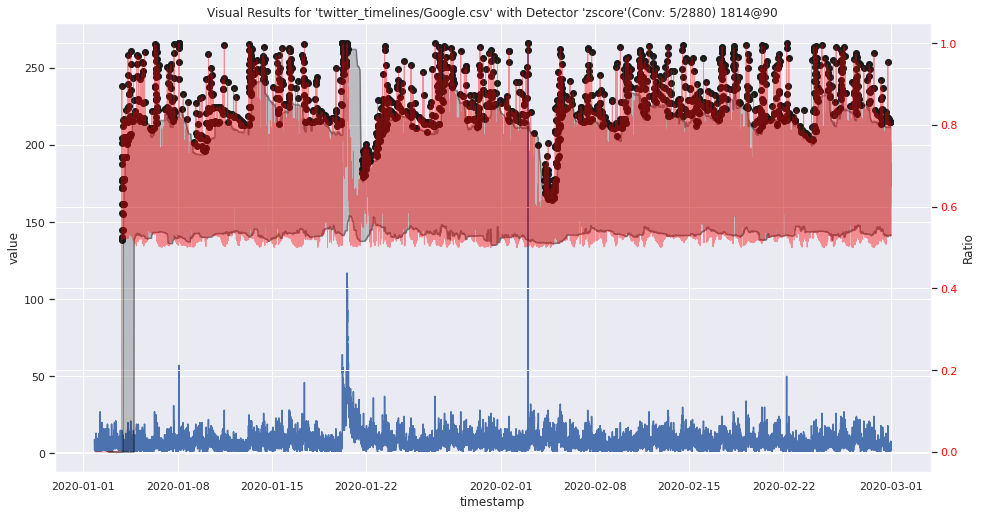

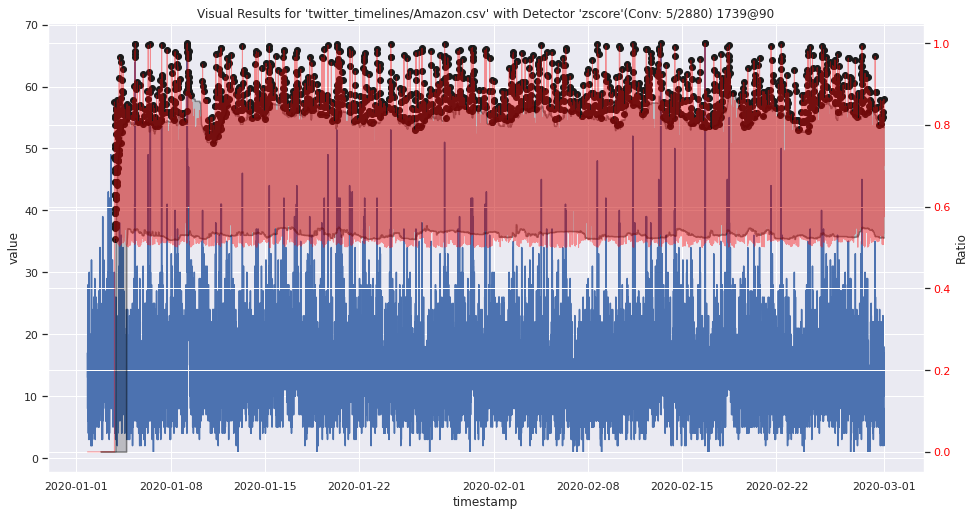

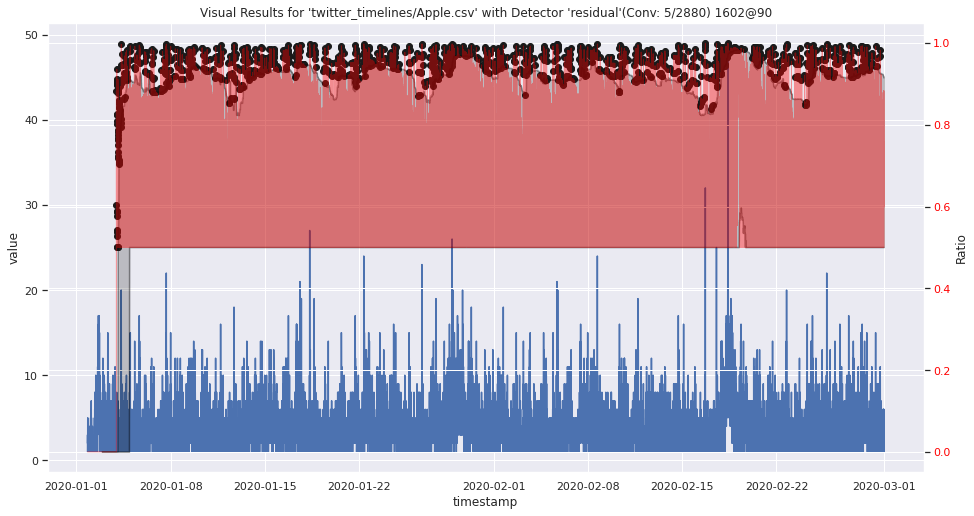

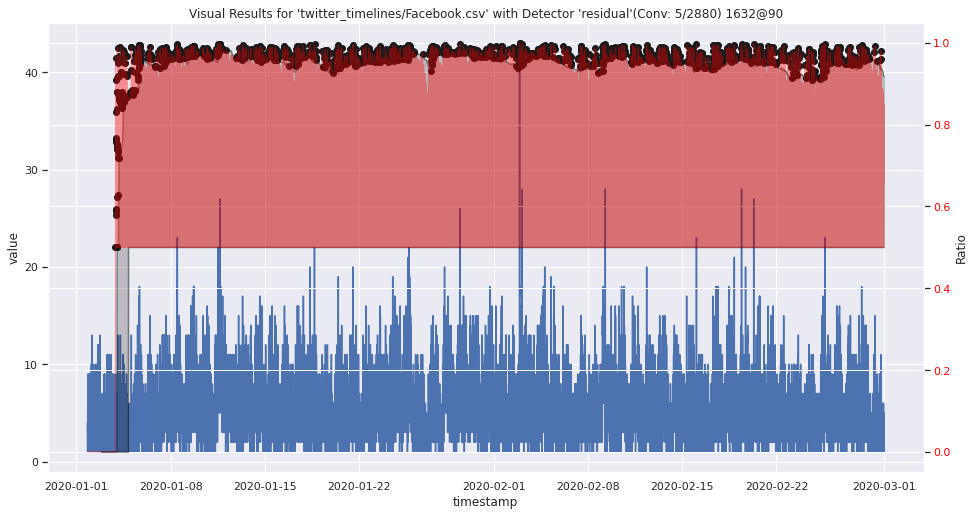

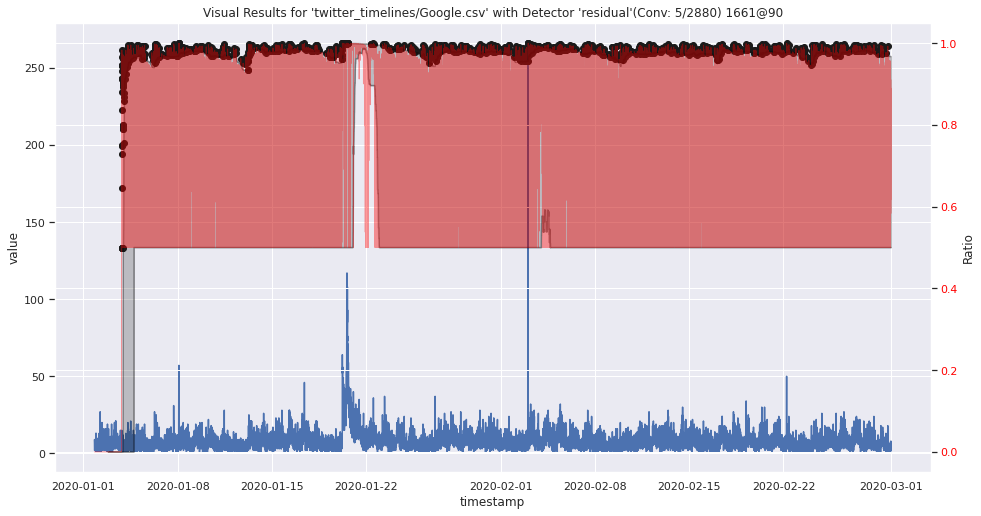

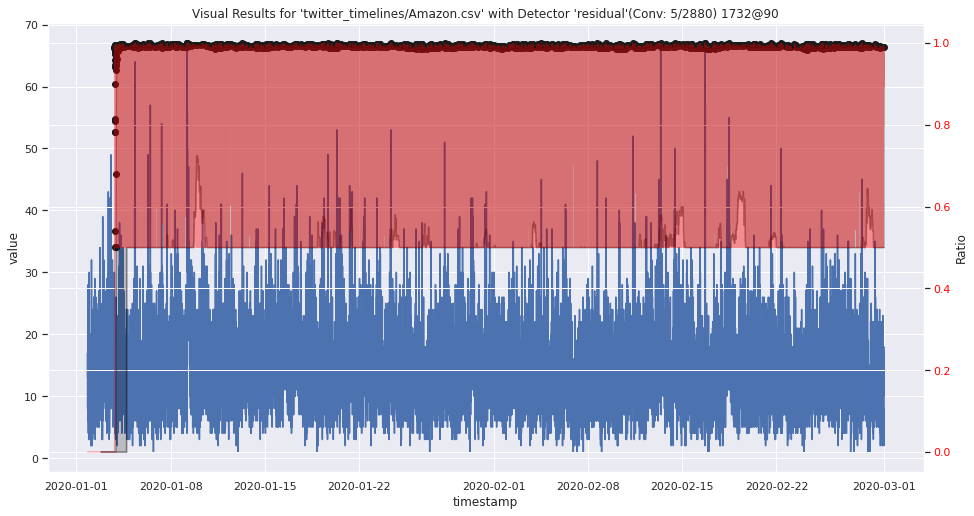

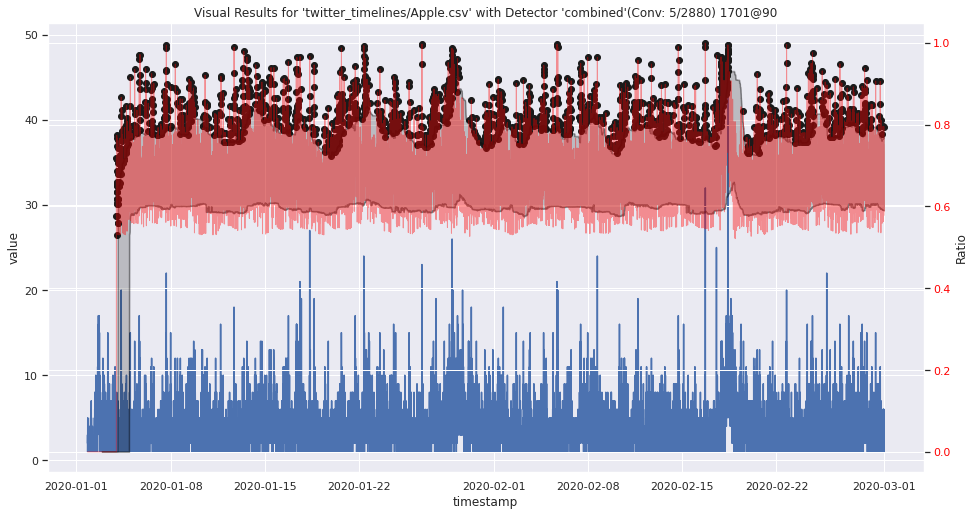

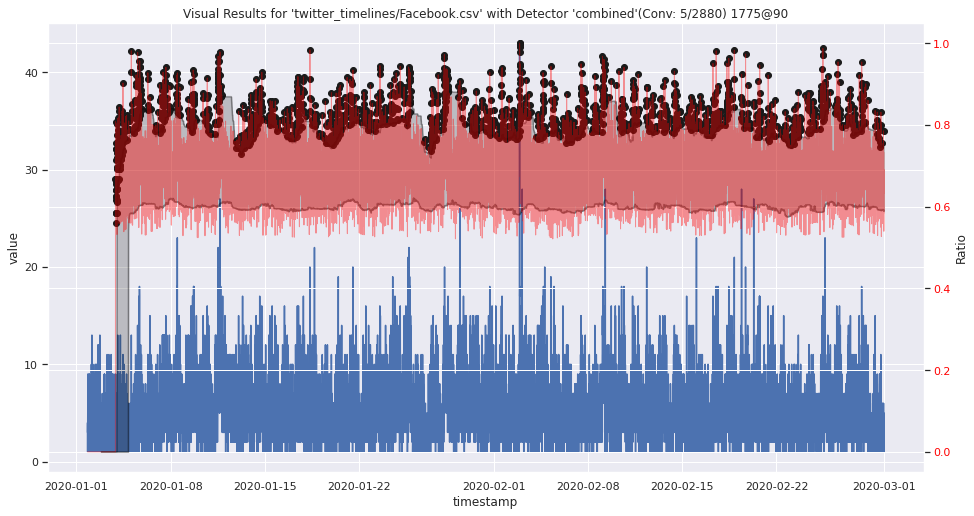

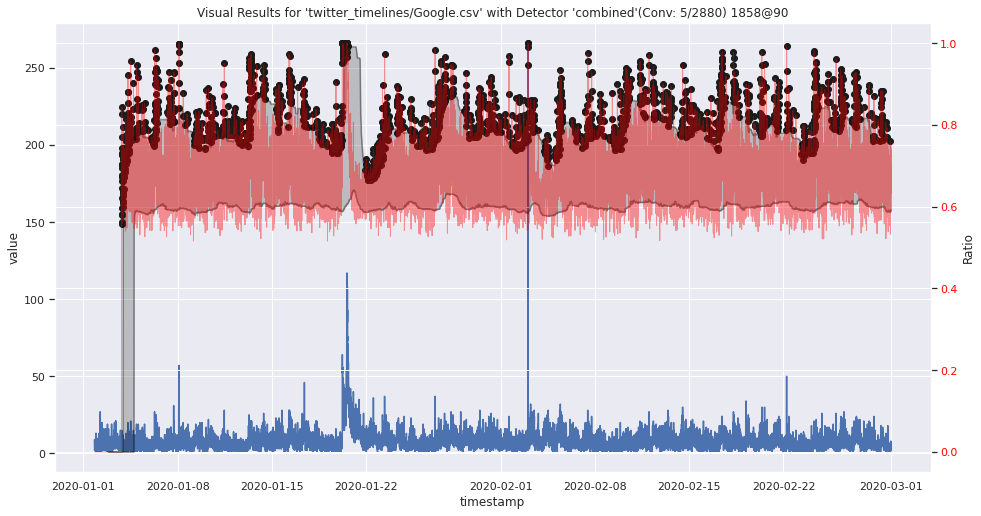

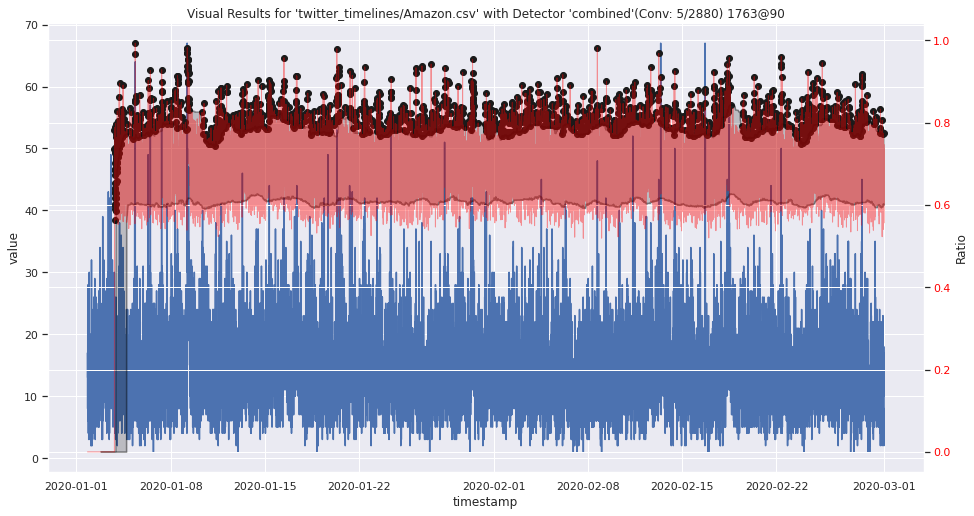

In [32]:
path_to_csv = "/home/../twitter_timelines/"
output_folder = "/home/../twitter_results/"
verbosity = 2

pdf = matplotlib.backends.backend_pdf.PdfPages("anomaly_plots.pdf")
timelines = ["Apple.csv", "Facebook.csv", "Google.csv", "Amazon.csv"]


results = {}
# grid search
vals_small = [5]
vals_large = [2880]
detectors = ["ratio", "zscore", "residual", "combined"]

datasets = [f for f in os.listdir(path_to_csv) if isfile(join(path_to_csv, f))]

for detector in detectors:
    if verbosity >= 1:
        print("Starting GridSearch - Params: {}/{} with detector {}".format(s, l, detector))

    for dataset in datasets:
        if verbosity >= 2:
            if dataset not in timelines:
                continue
            print("Next Dataset: '{}'".format(dataset))
        path_to_dataset = join(path_to_csv, dataset)
        path_to_output_file = join(output_folder + "anomaly_scores-" + dataset)
        process_dataset(path_to_dataset, path_to_output_file, s, l, detector, pdf)

pdf.close()

In [6]:
def thresholds(ratios, memory_size=12*5*24, percentile=90):
    N = int(memory_size / 5)
    percentiles = []
    
    for i in range(len(ratios) - N):
        percentiles.append(np.percentile(ratios[i:i+N], percentile))
        
    percentiles = np.asarray(percentiles)
    percentiles[percentiles == np.inf] = 0
    
    return percentiles

In [31]:
def process_dataset(path_to_dataset, path_to_output_file, p_small, p_large, detector, pdf=None):

    # general parameters
    window_small = p_small
    window_large = p_large

    # load data
    df = pd.read_csv(path_to_dataset)
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
    
    scores = None

    
    # convolutions
    if detector == "ratio":
        scores_ratio = convolve(df["value"], window_small, window_large)[1:]
        scores = scores_ratio
    elif detector == "zscore":
        scores_zscore = convolve_zscore(df["value"], window_small, window_large)
        scores = scores_zscore
    elif detector == "residual":
        scores_residual = convolve_residual(df["value"], window_small, window_large)    
        scores = scores_residual
    elif detector == "combined":
        scores_ratio = convolve(df["value"], window_small, window_large)[1:]
        scores_zscore = convolve_zscore(df["value"], window_small, window_large)
        #scores_residual = convolve_residual(df["value"], window_small, window_large)
        #scores = (scores_ratio * scores_zscore * scores_residual) ** (1/3)
        scores = (scores_ratio * scores_zscore) ** (1/2)

    else:
        print("Invalid detector found: {}. Please choose from ['ratio', 'zscore', 'residual']".format(detector))
    #scores = ((np.tanh(scores_ratio) + 1) * (np.tanh(scores_zscore) + 1)* (np.tanh(scores_residual) + 1)) ** (1/3)
    #scores = np.tanh(scores_ratio) + np.tanh(scores_zscore) + np.tanh(scores_residual)
    
    stride = df.shape[0] - scores.shape[0]
    scores = np.insert(scores, 0, [0] * stride, axis=0)
    df["anomaly_score"] = scores
    
    # write results to csv
    df.to_csv(path_to_output_file, sep=",", index=False)
    
    # optional plotting
    if pdf is not None: 
        # plot original timeseries
        sns.set(rc={'figure.figsize':(15.7,8.27)})
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        sns.lineplot(x="timestamp", y="value", data=df, ax=ax1)
        print(df)

        percentile=90

        # plot confidence bands
        t_upper = thresholds(scores, percentile=percentile)
        t_lower = thresholds(scores, percentile=100-percentile)

        stride = df.shape[0] - t_upper.shape[0]

        #ax2.tick_params(axis="y", labelcolor="red")
        ax2.plot(df["timestamp"][stride:], t_lower, color="black", alpha=0.3)
        ax2.plot(df["timestamp"][stride:], t_upper, color="black", alpha=0.3)
        ax2.fill_between(df["timestamp"][stride:], t_lower, t_upper, alpha=0.2, color="black")

        # plot convolutions
        sns.lineplot(x="timestamp", y="anomaly_score", data=df, color="red",  linewidth=1, ax=ax2, alpha=0.4)
        ax2.set_ylabel("Ratio")
        ax2.tick_params(axis="y", labelcolor="red")
        # ax2.set_yscale("log")
        # ax2.set_ylim([-.3, window_large/window_small * 1.2])
        #ax2.set_ylim([-3.5, 3.5])



        # plot anomaly circles
        x_anom = np.squeeze(np.argwhere(scores[stride:] > t_upper))
        y_anom = scores[stride:][x_anom]

        ax2.scatter(df["timestamp"][stride:].iloc[x_anom], y_anom, color="k")


        plt.title("Visual Results for '{}' with Detector '{}'(Conv: {}/{}) {}@{}".format("/".join(path_to_dataset.split("/")[-2:]), detector, p_small, p_large, y_anom.shape[0], percentile))
        #plt.savefig(path_to_output_file.replace("csv", "pdf").replace("results", "plots"), bbox_inches='tight')
        pdf.savefig(fig, bbox_inches='tight')